In [7]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
sc.settings.verbosity = 3

In [8]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [9]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import scSpaMet as spamet

In [11]:
experiment = "endometrium"
cores = ["L128"]
datasets = ["L11_2", "L11_3"]+[core + f"_{i}" for core in cores for i in range(1, 4)]

In [12]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


# Load data

In [13]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [14]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [15]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
adata = adata[~adata.obs.Dataset.isin(['F7_1', 'F7_2'])]
adata_IMC = adata_IMC_cluster[~adata_IMC_cluster.obs.Dataset.isin(['F7_1', 'F7_2'])]

In [19]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
# mz_qc = df_sum[(df_sum > 16000)].index.tolist()
mz_qc = df_sum[(df_sum > 6000)].index.tolist()

In [20]:
df_sum 

1.0        1402.456701
12.0       2735.992446
13.0      12847.610014
14.0     343037.893689
15.0     629932.177484
             ...      
221.9      6417.500514
228.9     16076.675840
233.9      7226.838879
237.9      5124.135022
242.9      3631.294195
Length: 192, dtype: float64

In [21]:
len(mz_qc)

184

In [22]:
adata = adata[:, mz_qc]
adata_raw = adata_raw[:, mz_qc]

In [23]:
# Define IMC and SIMS marker list
IMC_markers = adata.var_names.tolist()
SIMS_masses = adata_IMC.var_names.tolist()

# Joint embedding

In [24]:
def Umap(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.pp.neighbors(a,use_rep=rep, metric='cosine')
    else:
        sc.pp.neighbors(a)
    sc.tl.umap(a)
    print('Sucessfully run Umap!')
    return a

def TSNE(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.tl.tsne(a,use_rep=rep)
    else:
        sc.tl.tsne(a)
    print('Sucessfully run TSNE!')
    return a

In [25]:
train_x_IMC = adata_IMC.X
train_x_SIMS = adata.X

In [26]:
# X_embedding, _, _ = spamet.tl.Joint_XVAE_clustering(train_x_IMC, train_x_SIMS, epochs=20)
X_embedding, q, X_predict = spamet.tl.Joint_XVAE_clustering(train_x_IMC, train_x_SIMS, epochs=100, resolution=0.3)

GPU name:  []


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
257/257 - 2s - loss: 0.7074 - reconstruction_loss: 0.6915 - kl_loss: 1.5934 - 2s/epoch - 7ms/step
Epoch 2/100
257/257 - 0s - loss: 0.5693 - reconstruction_loss: 0.5629 - kl_loss: 0.6371 - 412ms/epoch - 2ms/step
Epoch 3/100
257/257 - 0s - loss: 0.5326 - reconstruction_loss: 0.5285 - kl_loss: 0.4093 - 414ms/epoch - 2ms/step
Epoch 4/100
257/257 - 0s - loss: 0.5202 - reconstruction_loss: 0.5163 - kl_loss: 0.3839 - 414ms/epoch - 2ms/step
Epoch 5/100
257/257 - 0s - loss: 0.5131 - reconstruction_loss: 0.5091 - kl_loss: 0.3986 - 411ms/epoch - 2ms/step
Epoch 6/100
257/257 - 0s - loss: 0.5031 - reconstruction_loss: 0.4989 - kl_loss: 0.4229 - 409ms/epoch - 2ms/step
Epoch 7/100
257/257 - 0s - loss: 0.4847 - reconstruction_loss: 0.4799 - kl_loss: 0.4805 - 415ms/epoch - 2ms/step
Epoch 8/100
257/257 - 0s - loss: 0.4758 - reconstruction_loss: 0.4711 - kl_loss: 0.4725 - 415ms/epoch - 2ms/step
Epoch 9/100
257/257 - 0s - loss: 0.4702 - reconstruction_loss: 0.4653 - kl_loss: 0.4917 - 403ms/epo

Y:\coskun-lab\Thomas\ScSpaMet\src\scSpaMet\tools\_Joint_XVAE_clustering.py:235: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  y0.cat.categories=range(0,len(y0.cat.categories))


257/257 [==============================] - 0s 986us/step


## Check reconstruction

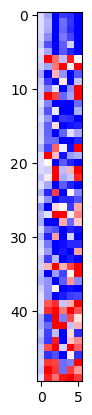

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(train_x_IMC[:50,:], cmap='bwr', vmin=-0.5, vmax=0.5)
plt.show()

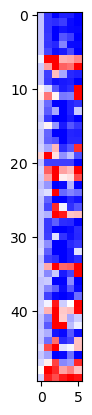

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(X_predict[0][:50,:], cmap='bwr', vmin=-0.5, vmax=0.5)
plt.show()

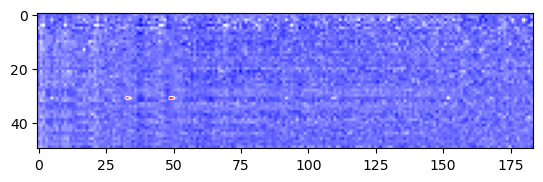

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(train_x_SIMS[:50,:], cmap='bwr')
plt.show()

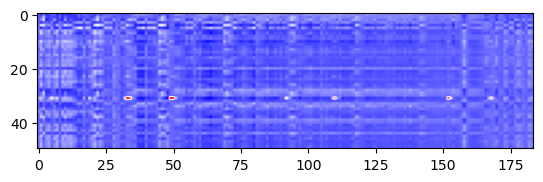

In [30]:
fig, ax = plt.subplots()
im = ax.imshow(X_predict[1][:50,:], cmap='bwr')
plt.show()

## Analysis

In [31]:
y_pred=pd.Series(np.argmax(q,axis=1),index=adata.obs.index,dtype='category')
y_pred.cat.categories=list(range(len(y_pred.unique())))

C:\Users\thu71\AppData\Local\Temp\ipykernel_21676\136628964.py:2: FutureWarning: Setting categories in-place is deprecated and will raise in a future version. Use rename_categories instead.
  y_pred.cat.categories=list(range(len(y_pred.unique())))


In [32]:
adata.obsm['Joint'] = X_embedding[0]

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
Umap(adata,rep='Joint')


Using representation Joint
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
Sucessfully run Umap!


AnnData object with n_obs × n_vars = 8215 × 184
    obs: 'Cell', 'Dataset', 'Core'
    uns: 'neighbors', 'umap'
    obsm: 'spatial', 'Joint', 'X_umap'
    obsp: 'distances', 'connectivities'

In [34]:
adata.obs['leiden'] = y_pred.astype(str)
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


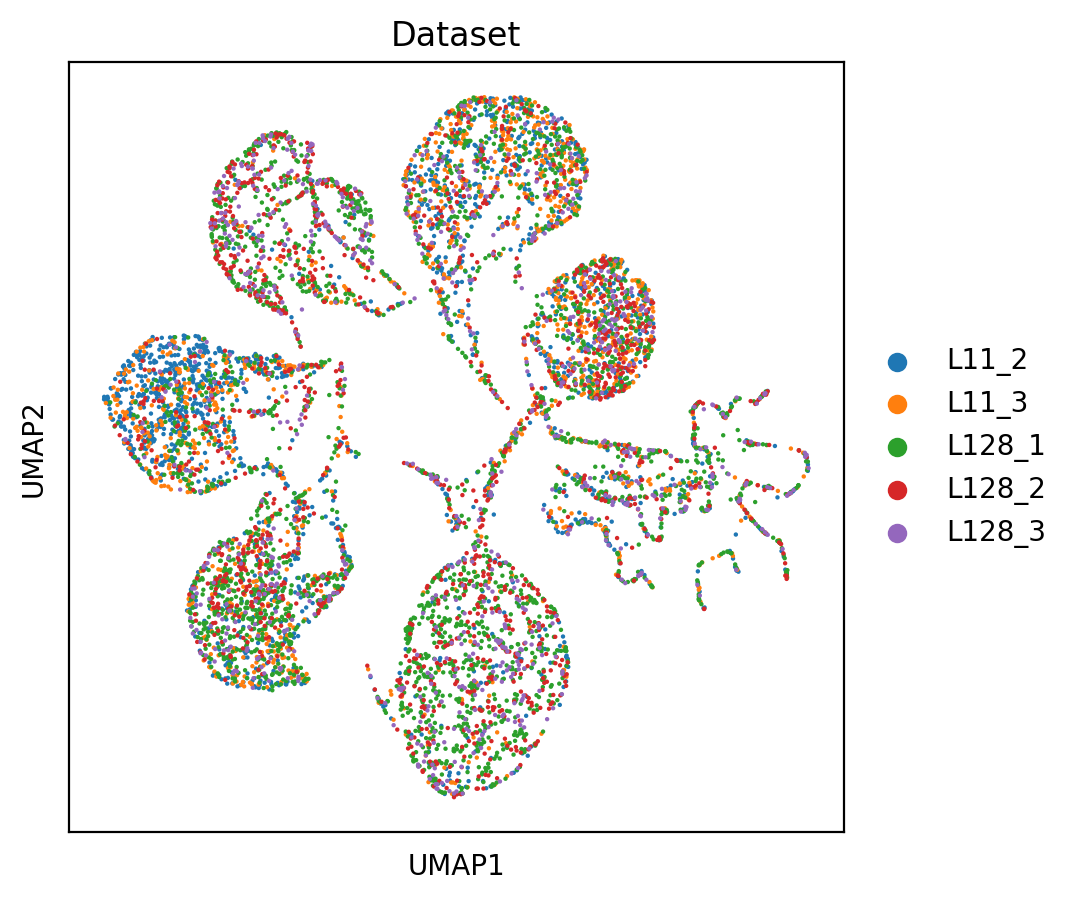

In [35]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.umap(adata, color=["Dataset"], size=10)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


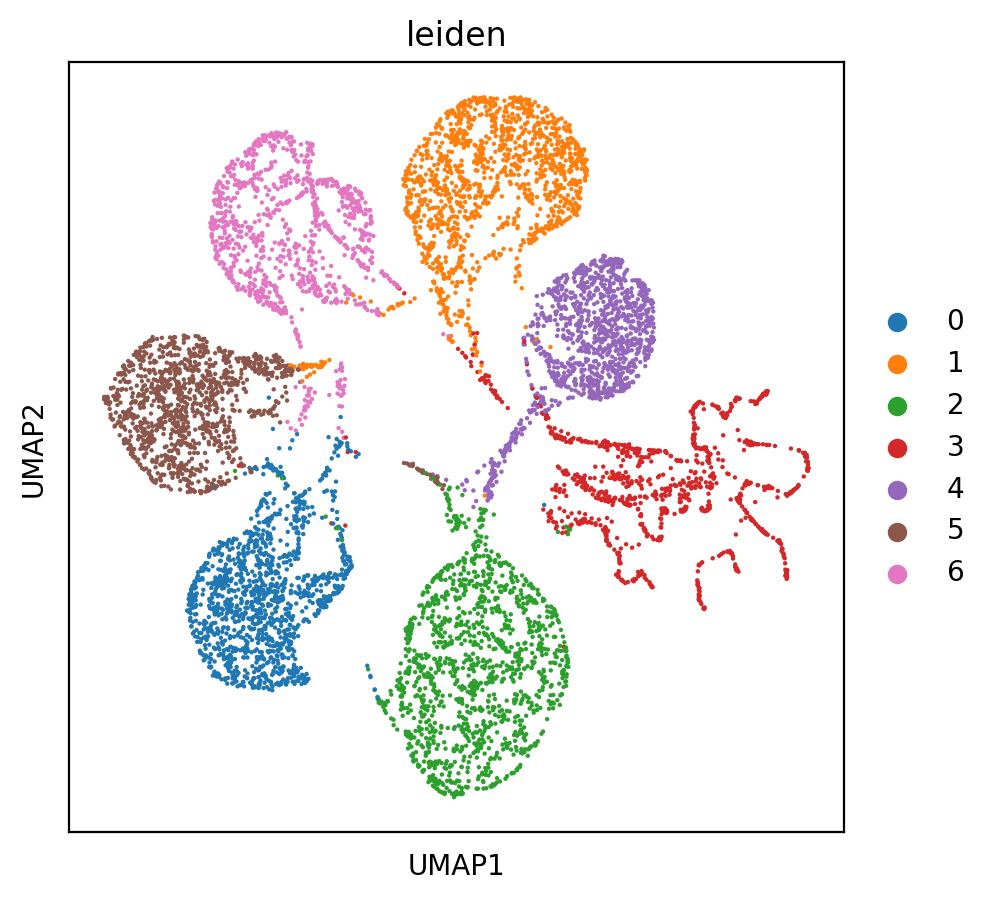

In [36]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.umap(adata, color=["leiden"], size=10)

In [37]:
TSNE(adata,rep='Joint')

Using representation Joint
computing tSNE
    using sklearn.manifold.TSNE


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:22)
Sucessfully run TSNE!


AnnData object with n_obs × n_vars = 8215 × 184
    obs: 'Cell', 'Dataset', 'Core', 'leiden'
    uns: 'neighbors', 'umap', 'Dataset_colors', 'leiden_colors', 'tsne'
    obsm: 'spatial', 'Joint', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


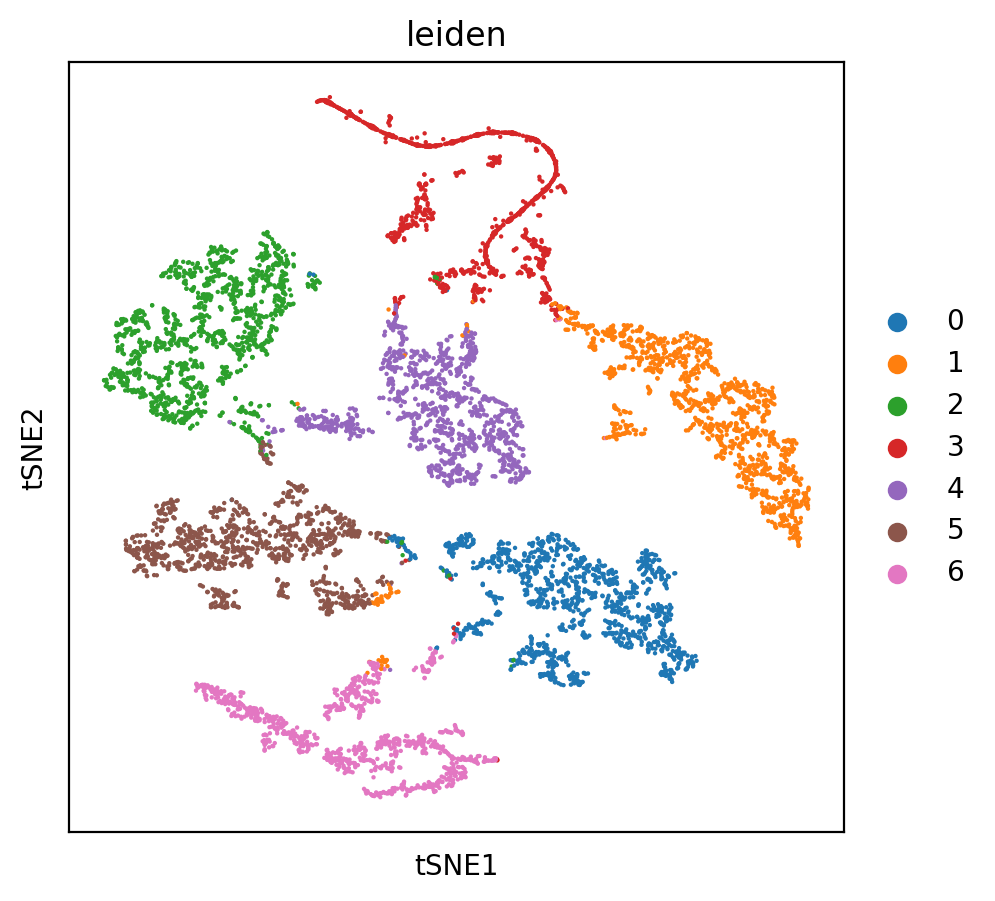

In [38]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.tsne(adata, color=["leiden"], size=10)

In [39]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test_overestim_var')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.l

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


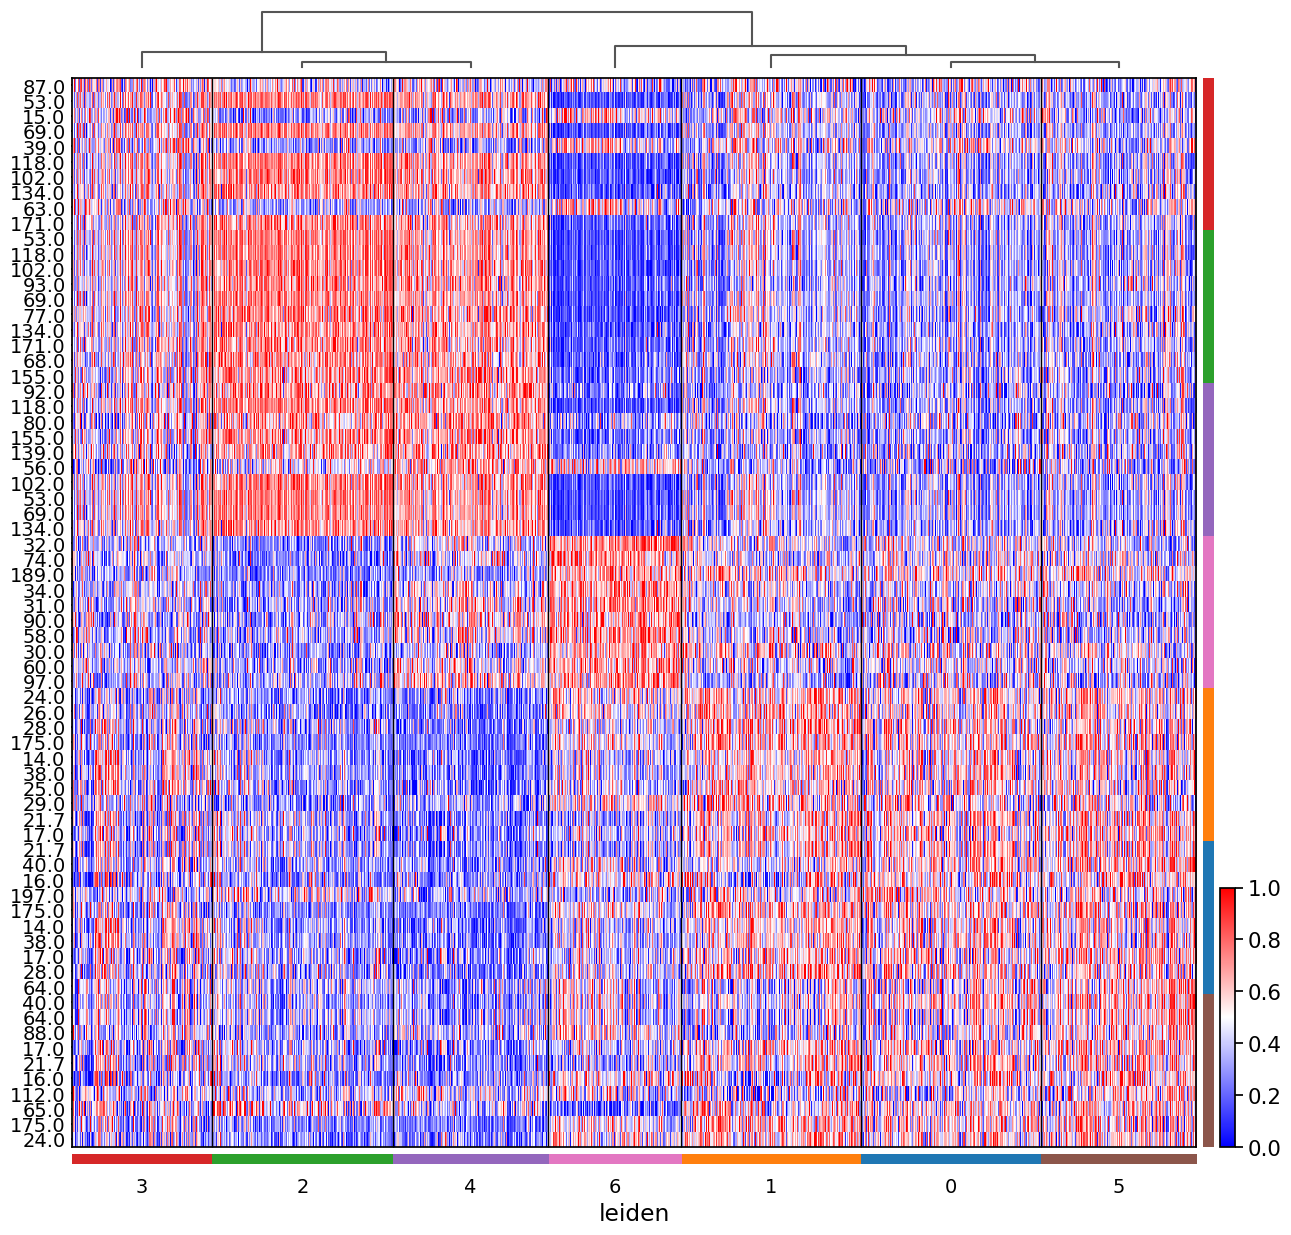

In [40]:
sns.set_context("notebook", font_scale=1.4)

dp_object =  sc.pl.rank_genes_groups_heatmap(adata, groupby='leiden', standard_scale='obs', cmap='bwr', 
                                             dendrogram=True, figsize=(15, 15), show_gene_labels=True, 
                                             swap_axes=True)

In [41]:
dedf = sc.get.rank_genes_groups_df(adata, group=None)
# Get top diff expression
topk=7
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

In [42]:
adata_subset = adata[:, masses]


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


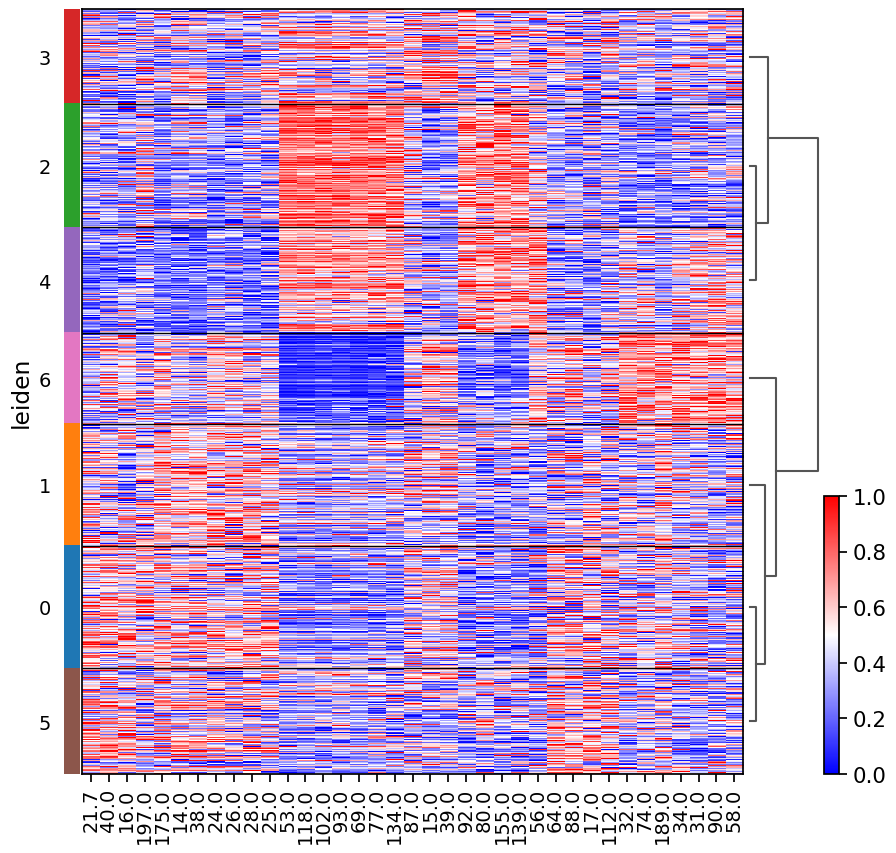

In [43]:
sc.pl.heatmap(
    adata_subset,
    adata_subset.var_names.tolist(),
    'leiden',
    dendrogram=True,
    cmap='bwr',
    figsize=(10, 10),
    standard_scale='obs',
    log=False,
    show_gene_labels=True
)



# Viz

In [44]:
adata_IMC.obs = adata_IMC.obs.reset_index(drop=True)
adata.obs = adata.obs.reset_index(drop=True)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [45]:
adata_IMC.obs['leiden_joint'] = adata.obs['leiden']

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden_joint']`


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


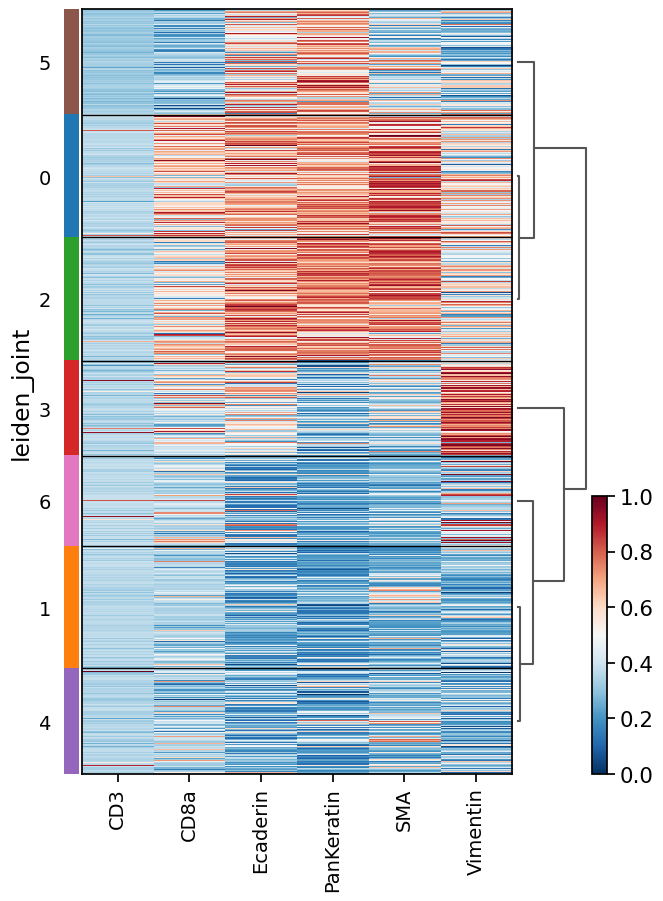

In [46]:
sc.tl.dendrogram(adata_IMC, 'leiden_joint')
sc.pl.heatmap(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    'leiden_joint',
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
    standard_scale='var'
)

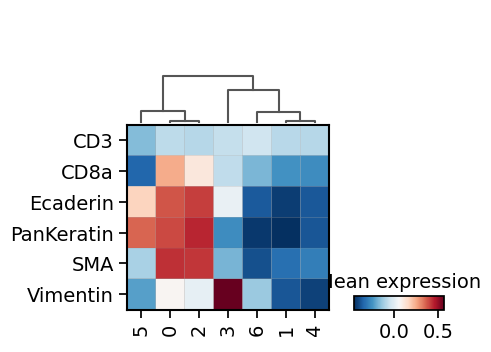

In [47]:
sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    'leiden_joint',
    dendrogram=True,
    colorbar_title="Mean expression",
    cmap="RdBu_r", 
    swap_axes=True,
)

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


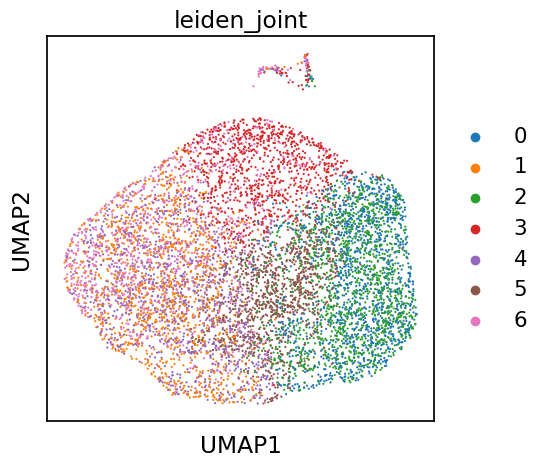

In [48]:

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=['leiden_joint'], size=10)

In [53]:
import matplotlib 
cluster_label_order = adata_IMC.uns['dendrogram_leiden_joint']['categories_ordered']

colors = adata_IMC.uns["leiden_joint_colors"]
labels = adata_IMC.obs.leiden_joint.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

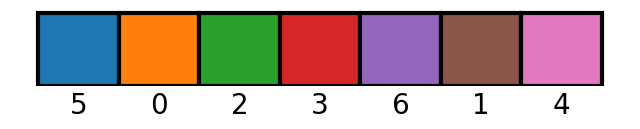

In [66]:
# legend
fig, ax = plt.subplots(figsize=(8,1))
ax.bar(x=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.xticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=20)
_ = plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(False)
plt.show()

# Save data

In [55]:
# path = data_dir / 'joint' / f'{experiment}.h5ad' 
# adata.write(path)

# Plot masks

In [56]:
import matplotlib
import skimage


# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img

In [57]:
masks = get_masks(data_dir / "masks")

In [58]:
colors = adata_IMC.uns["leiden_joint_colors"]
labels = np.unique(adata_IMC.obs.leiden_joint.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

L11_2


  0%|          | 0/7 [00:00<?, ?it/s]

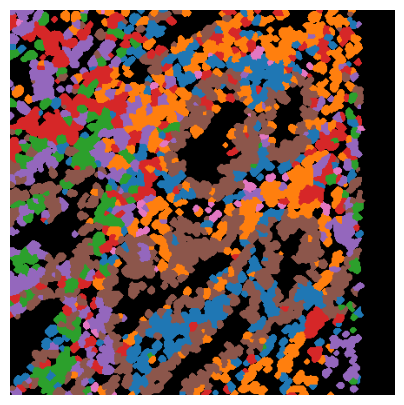

L11_3


  0%|          | 0/7 [00:00<?, ?it/s]

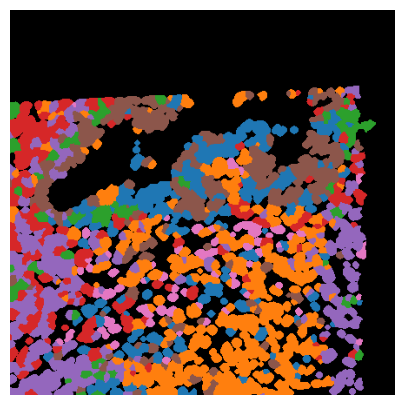

L128_1


  0%|          | 0/7 [00:00<?, ?it/s]

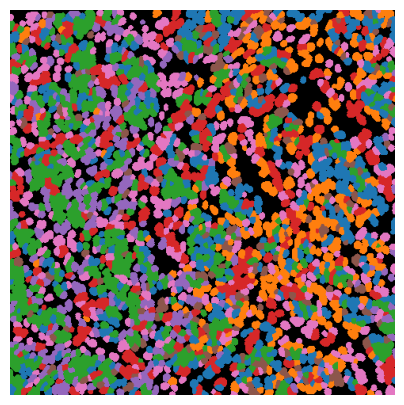

L128_2


  0%|          | 0/7 [00:00<?, ?it/s]

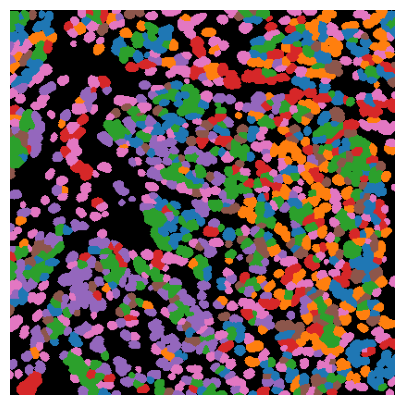

L128_3


  0%|          | 0/7 [00:00<?, ?it/s]

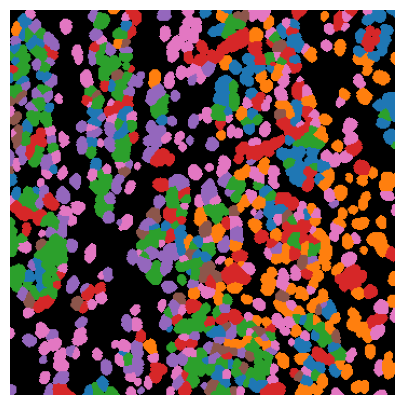

In [65]:
experiment = 'endometrium'

for dataset in datasets:
    print(dataset)
    try:
        adata_subset = adata_IMC[adata_IMC.obs.Core == dataset, :]
        mask = masks[experiment + '_' + dataset]

        # Get label2cell dict
        label2cell = {}
        for l in labels:
            cell_id = adata_subset[adata_subset.obs.leiden_joint == l].obs.Cell.to_list()
            label2cell[l] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(img)
        ax.axis("off")
        plt.show()
    except:
        pass

In [68]:
# adata.write_h5ad(data_dir / "adata" / f"{experiment}_vae.h5ad")

In [60]:
adata

AnnData object with n_obs × n_vars = 8215 × 184
    obs: 'Cell', 'Dataset', 'Core', 'leiden'
    uns: 'neighbors', 'umap', 'Dataset_colors', 'leiden_colors', 'tsne', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'spatial', 'Joint', 'X_umap', 'X_tsne', 'X_pca'
    obsp: 'distances', 'connectivities'

In [61]:
sc.pp.neighbors(adata,use_rep='Joint', metric='jaccard')
sc.tl.umap(adata, n_components=3, min_dist=0.1, spread=2.0)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


Text(0.5, 0.5, '')

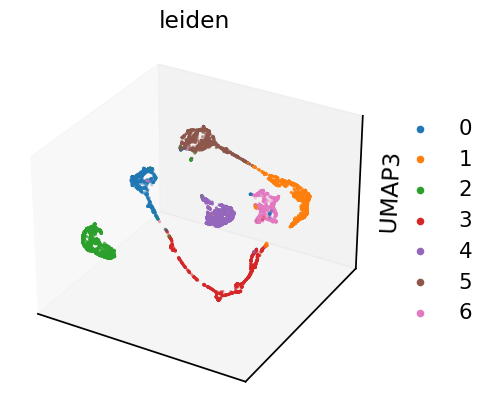

In [62]:
ax = sc.pl.umap(adata, color=["leiden"], projection='3d', return_fig=True)
plt.xlabel('')
plt.ylabel('')